# Welcome to the CloudtoStreet Machine Learning Challenge

Hi, I am Philip, the Machine Learning team lead here at CloudtoStreet. This challenge is testing your skills in training, evaluating and designing Deep Learning models for Computer Vision.

Depending on how often you have done such tasks, the challenge can take longer or shorter. We aim for 3-4 hours and don't expect your solution to be perfect, it's just helping us to see where you are and will inform the questions we will ask in the interviews.

__You can (and should because of time constraints) re-use code (models, datasets, training loops) from open sources or your personal work as long as you cite them.__

Note: If you do not have a GPU at hand, you can use https://www.kaggle.com/kernels, https://colab.research.google.com/ for free GPUs or rent a cheap GPU at https://vast.ai/console/create/.

__Some specific tasks for you are tagged in this notebook with "Todo". Please follow these prompts and add any cells you need.__

Good luck!

In [1]:
# these are the packages we need for exploration, please install them e.g. in colab you need !pip install rasterio
import os
import glob
import matplotlib.pyplot as plt
import tifffile
import numpy as np

from matplotlib.collections import PatchCollection
from shapely.geometry import Polygon
from rasterio.features import shapes
from descartes import PolygonPatch

In [2]:
#BH: packages I brought in myself

import pandas as pd
import tensorflow as tf

In [3]:
#BH: Some known constants

IMAGE_HEIGHT = 512
IMAGE_WIDTH = 512
IMAGE_SIZE = IMAGE_HEIGHT * IMAGE_WIDTH
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Setup

We will use our [Sen1Floods11](https://github.com/cloudtostreet/Sen1Floods11) dataset. We will create a local folder `c2s_data/v1.1/data/flood_events/HandLabeled` and download the handlabeled training data (Sentinel-1 512x512 chips, mask labels) there.

In [4]:
if False:
    os.makedirs("c2s_data/v1.1/data/flood_events/HandLabeled", exist_ok=True)

    !pip install gsutil
    !gsutil -m rsync -r gs://sen1floods11/v1.1/data/flood_events/HandLabeled c2s_data/v1.1/data/flood_events/HandLabeled

There are some faulty labels we will remove here.

In [5]:
def remove_faulty(img_folder="c2s_data/v1.1/data/flood_events/HandLabeled/S1Hand", 
                  label_folder="c2s_data/v1.1/data/flood_events/HandLabeled/LabelHand"):
    for uid in [
        'Ghana_141910',
        'Ghana_866994',
        'Mekong_1111068',
        'Pakistan_35915',
        'Pakistan_94095',
        'Paraguay_34417',
        'Paraguay_581976',
        'Spain_6095801'
    ]:
        
        faulty_img = f"{img_folder}/{uid}_S1Hand.tif"
        if os.path.exists(faulty_img):
            print('removing: ', faulty_img)
            os.remove(faulty_img)

        faulty_label = f"{label_folder}/{uid}_LabelHand.tif"
        if os.path.exists(faulty_label):
            print('removing: ', faulty_label)
            os.remove(faulty_label)

remove_faulty()

## Helper functions

In [6]:
def get_patchcollection_from_label(label, label_value=1, alpha=1, color="cyan"):
    """Turns a (H,W) mask into a PatchCollection of polygons"""
    polygons, colors = [], []
    for geom in shapes((label == label_value).astype(np.uint8), mask=(label == label_value).astype(np.uint8),
                       connectivity=4):
        poly = Polygon(geom[0]['coordinates'][0], holes=geom[0]['coordinates'][1:])
        polygons.append(PolygonPatch(poly.buffer(0)))
        colors.append(color)
    return PatchCollection(polygons, facecolor=colors, linewidths=0, alpha=alpha)

def visualize_s1_img(path):
    """Opens a Sentinel 1 image and returns a scaled RFCC false color composite image for visualization."""
    s1_img = tifffile.imread(path)
    if s1_img.shape[0] < 15: s1_img = np.transpose(s1_img, (1, 2, 0))
    if s1_img.shape[-1] == 3: s1_img = s1_img[:, :, :2]
    img = np.zeros((s1_img.shape[0], s1_img.shape[1], 3), dtype=np.float32)
    img[:, :, :2] = s1_img
    img[:, :, 2] = s1_img[:, :, 0] / s1_img[:, :, 1]
    return scale_S1_S2_img(img)

def scale_S1_S2_img(matrix):
    """Returns a scaled (H,W,D) image which is more easily visually inspectable. Image is linearly scaled between
    min and max_value of by channel"""
    w, h, d = matrix.shape
    min_values = np.array([-23, -28, 0.2])
    max_values = np.array([0, -5, 1])

    matrix = np.reshape(matrix, [w * h, d]).astype(np.float64)
    matrix = (matrix - min_values[None, :]) / (max_values[None, :] - min_values[None, :])
    matrix = np.reshape(matrix, [w, h, d])

    matrix = matrix.clip(0, 1)
    return matrix

# Part 1: Practical Deep Learning

## Exploration and Splitting

In the folder "S1Hand" we have 438 512x512 Sentinel-1 images from 11 countries. The folder "LabelHand" contains the water/no data masks for these images. 

Our goal is to have a model that achieves high mean Intersection over Union over all countries. 

__Todo__
- Look at the images with the code that is given. Re-run it to see different random examples from the dataset.
- Explore the images and labels. Summarize your findings with relevant statistics and visualizations.
- Split the data into useful train/validation/test datasets

In [7]:
# Countries we have data for
countries_present = list(set([k.split("/")[-1].split("_")[0] for k in glob.glob("c2s_data/v1.1/data/flood_events/HandLabeled/S1Hand/*.tif")]))
print(countries_present)

['Bolivia', 'Spain', 'Mekong', 'Sri-Lanka', 'Nigeria', 'Somalia', 'Paraguay', 'India', 'USA', 'Ghana', 'Pakistan']


In [8]:
S1_imgs = sorted(glob.glob("c2s_data/v1.1/data/flood_events/HandLabeled/S1Hand/*.tif"))
labels_GT = sorted(glob.glob("c2s_data/v1.1/data/flood_events/HandLabeled/LabelHand/*.tif"))
print(len(S1_imgs), len(labels_GT))

438 438


For Visualization we are using a false color composite of the two Sentinel-1 channels and some color stretching. 

The label masks are 1 for water pixels (shown in cyan) and -1 for no data, e.g. clouds on the Sentinel-2 image we labeled the data on (shown in magenta).

Paraguay_36146_S1Hand.png


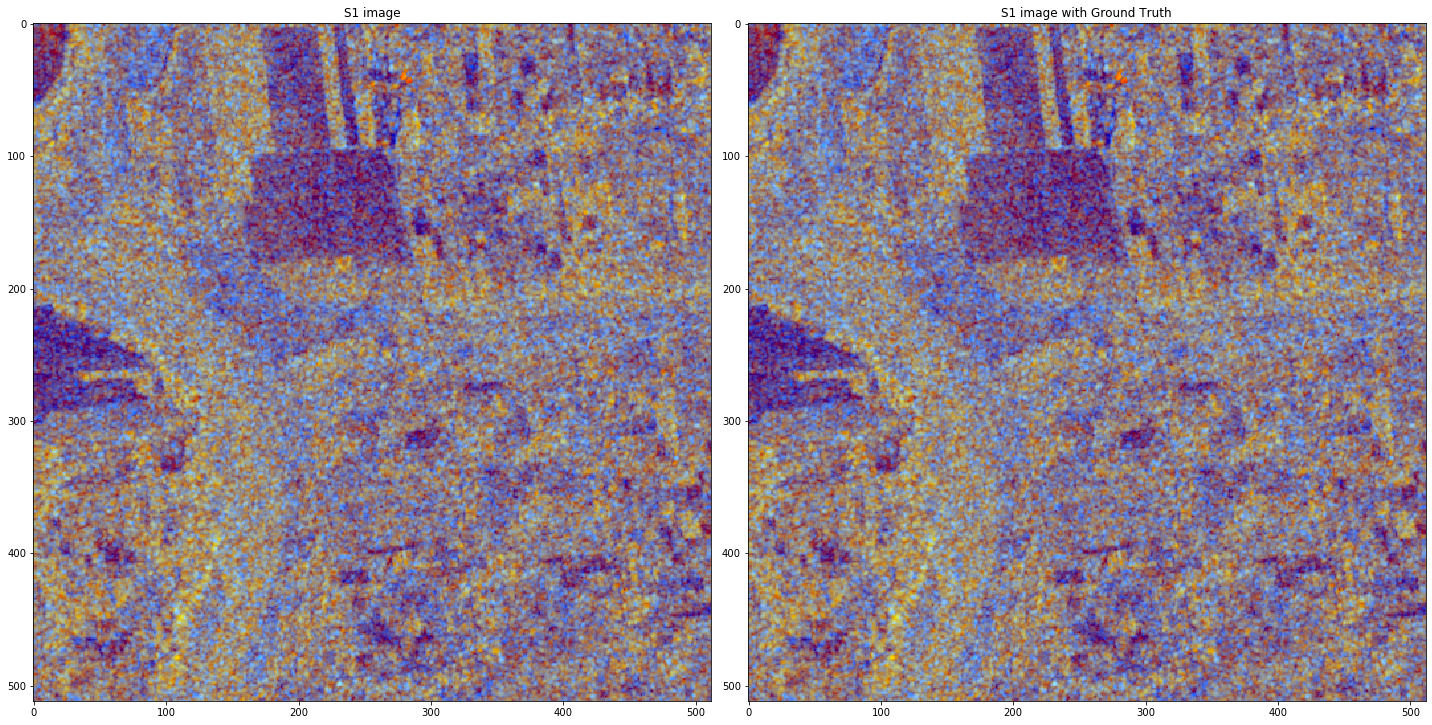

Ghana_406026_S1Hand.png


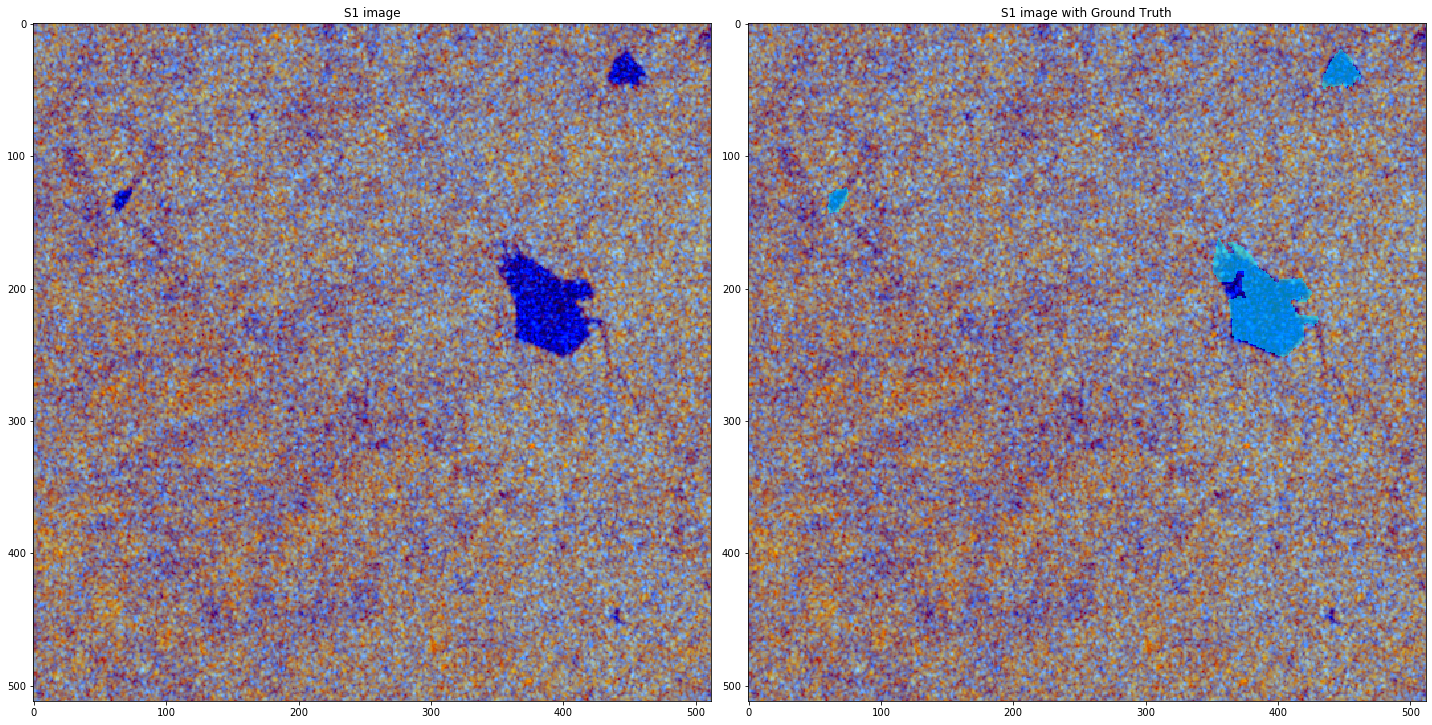

In [9]:
# plot random tiles
# S1 image on the left, and the S1 image with the hand-labels overlain on the right.
show_how_many = 2
color = "cyan"
no_data_color = "magenta"
alpha = 0.5
for k in range(show_how_many):
    rand_int = np.random.randint(len(S1_imgs))
    filename = S1_imgs[rand_int].split("/")[-1].split(".")[0] + ".png"
    f, axarr = plt.subplots(1, 2, figsize=(20, 10))
    print(filename)
    img = visualize_s1_img(S1_imgs[rand_int])
    axarr[0].imshow(img)
    axarr[0].set_title("S1 image")
    axarr[1].imshow(img)
    axarr[1].set_title("S1 image with Ground Truth")
         
    label = tifffile.imread(labels_GT[rand_int])
    p = get_patchcollection_from_label(label, alpha=alpha, color=color)
    axarr[1].add_collection(p)
    p = get_patchcollection_from_label(label, -1, alpha=alpha, color=no_data_color)
    axarr[1].add_collection(p)
    
    plt.tight_layout()
    plt.show()

In [10]:
# Generate a summary dataframe

perc_unknown_list = []
perc_water_known_list = []
perc_dry_known_list = []
country_list = []
asset_id_list = []
label_fp_list = []
image_fp_list = []

for i, filepath in enumerate(labels_GT):
    label = tifffile.imread(filepath)
    image_fp = S1_imgs[i]
    image = tifffile.imread(image_fp)
    
    asset_id = filepath.split("/")[-1].replace("_LabelHand.tif", "")
    country = filepath.split("/")[-1].split("_")[0]
    
    num_unknown_pixels = len(label[label == -1])
    num_dry_pixels = len(label[label == 0])
    num_water_pixels = len(label[label == 1])
    perc_unknown = num_unknown_pixels / IMAGE_SIZE
    try:
        perc_water_known = num_water_pixels / (IMAGE_SIZE - num_unknown_pixels)
        perc_dry_known = num_dry_pixels / (IMAGE_SIZE - num_unknown_pixels)
    except:
        perc_water_known = 0
        perc_dry_known = 0
        
    perc_unknown_list.append(perc_unknown)
    perc_water_known_list.append(perc_water_known)
    perc_dry_known_list.append(perc_dry_known)
    country_list.append(country)
    asset_id_list.append(asset_id)
    label_fp_list.append(filepath)
    image_fp_list.append(image_fp)
    
summary_df = pd.DataFrame.from_dict({'perc_unknown' : perc_unknown_list,
                                     'perc_water_known' : perc_water_known_list,
                                     'perc_dry_known' : perc_dry_known_list,
                                     'country' : country_list,
                                     'asset_id' : asset_id_list,
                                     'label_fp' : label_fp_list,
                                     'image_fp' : image_fp_list})

summary_df.set_index('asset_id', inplace = True)
summary_df

,perc_unknown,perc_water_known,perc_dry_known,country,label_fp,image_fp
asset_id,,,,,,
Bolivia_103757,0.664013,0.401490,0.598510,Bolivia,c2s_data/v1.1/data/flood_events/HandLabeled/La...,c2s_data/v1.1/data/flood_events/HandLabeled/S1...
Bolivia_129334,0.092812,0.658679,0.341321,Bolivia,c2s_data/v1.1/data/flood_events/HandLabeled/La...,c2s_data/v1.1/data/flood_events/HandLabeled/S1...
Bolivia_195474,0.003086,0.005935,0.994065,Bolivia,c2s_data/v1.1/data/flood_events/HandLabeled/La...,c2s_data/v1.1/data/flood_events/HandLabeled/S1...
Bolivia_23014,0.200901,0.037140,0.962860,Bolivia,c2s_data/v1.1/data/flood_events/HandLabeled/La...,c2s_data/v1.1/data/flood_events/HandLabeled/S1...
Bolivia_233925,0.425747,0.000007,0.999993,Bolivia,c2s_data/v1.1/data/flood_events/HandLabeled/La...,c2s_data/v1.1/data/flood_events/HandLabeled/S1...
...,...,...,...,...,...,...
USA_908474,0.000278,0.007044,0.992956,USA,c2s_data/v1.1/data/flood_events/HandLabeled/La...,c2s_data/v1.1/data/flood_events/HandLabeled/S1...
USA_933610,0.000446,0.014590,0.985410,USA,c2s_data/v1.1/data/flood_events/HandLabeled/La...,c2s_data/v1.1/data/flood_events/HandLabeled/S1...
USA_955053,0.000015,0.136713,0.863287,USA,c2s_data/v1.1/data/flood_events/HandLabeled/La...,c2s_data/v1.1/data/flood_events/HandLabeled/S1...


In [11]:
# Some data cleanup: take out images with low label quality

quality_threshold = .8
print("removing %d images because of low label quality" % len(summary_df[summary_df['perc_unknown'] >= quality_threshold]))
summary_df = summary_df[summary_df['perc_unknown'] < quality_threshold]

removing 15 images because of low label quality


In [12]:
# Form dataset splits, on a per-country level.
# Here I'm assuming images aren't overlapping, so there is no problem with having one country appear in all three splits.
# In fact, this must be the case since in the problem statement we're trying to maximise test IoU averaged over all countries.

train_perc = .8
val_perc = .1
test_perc = 1 - train_perc - val_perc

asset_splits = {'train' : [], 'val' : [], 'test' : []}

seed = 607
rng = np.random.default_rng(seed = seed)

for country in countries_present:
    country_assets = summary_df[summary_df['country'] == country].index
    country_assets = list(rng.permutation(country_assets))

    total_country_assets = len(country_assets)
    num_val_assets = np.int(np.ceil(total_country_assets * val_perc))
    num_test_assets = np.int(np.ceil(total_country_assets * test_perc))

    asset_splits['val'].extend(country_assets[:num_val_assets])
    asset_splits['test'].extend(country_assets[num_val_assets: num_test_assets + num_val_assets])
    asset_splits['train'].extend(country_assets[num_test_assets + num_val_assets:])

splits_dict = {asset_id : key for key in asset_splits for asset_id in asset_splits[key]}

In [13]:
# These are the final dataframes we'll use

summary_df = summary_df.merge(pd.DataFrame.from_dict(splits_dict, orient = 'index', columns = ['split']),
                              left_index = True, right_index = True)

train_df = summary_df[summary_df['split'] == 'train']
val_df = summary_df[summary_df['split'] == 'val']
test_df = summary_df[summary_df['split'] == 'test']

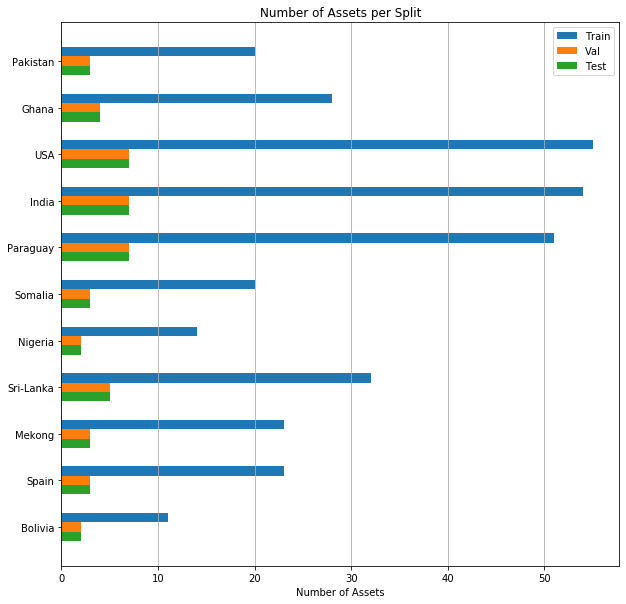

In [82]:
# Sanity check: Visualize the splits

train_counts = {country : len(train_df[train_df['country'] == country]) for country in countries_present}
val_counts = {country : len(val_df[val_df['country'] == country]) for country in countries_present}
test_counts = {country : len(test_df[test_df['country'] == country]) for country in countries_present}

y_pos = np.arange(len(countries_present))
width = 0.2

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1,1,1)
rects1 = ax.barh(y_pos + width, [train_counts[country] for country in countries_present], width, label='Train') # train "first"
rects2 = ax.barh(y_pos, [val_counts[country] for country in countries_present], width, label='Val') # val "middle"
rects3 = ax.barh(y_pos - width, [test_counts[country] for country in countries_present], width, label='Test')   # test "below"

ax.set_xlabel('Number of Assets')
ax.set_title('Number of Assets per Split')
ax.set_yticks(y_pos)
ax.set_yticklabels(countries_present)

ax.legend()
ax.grid(axis='x')
fig.show()

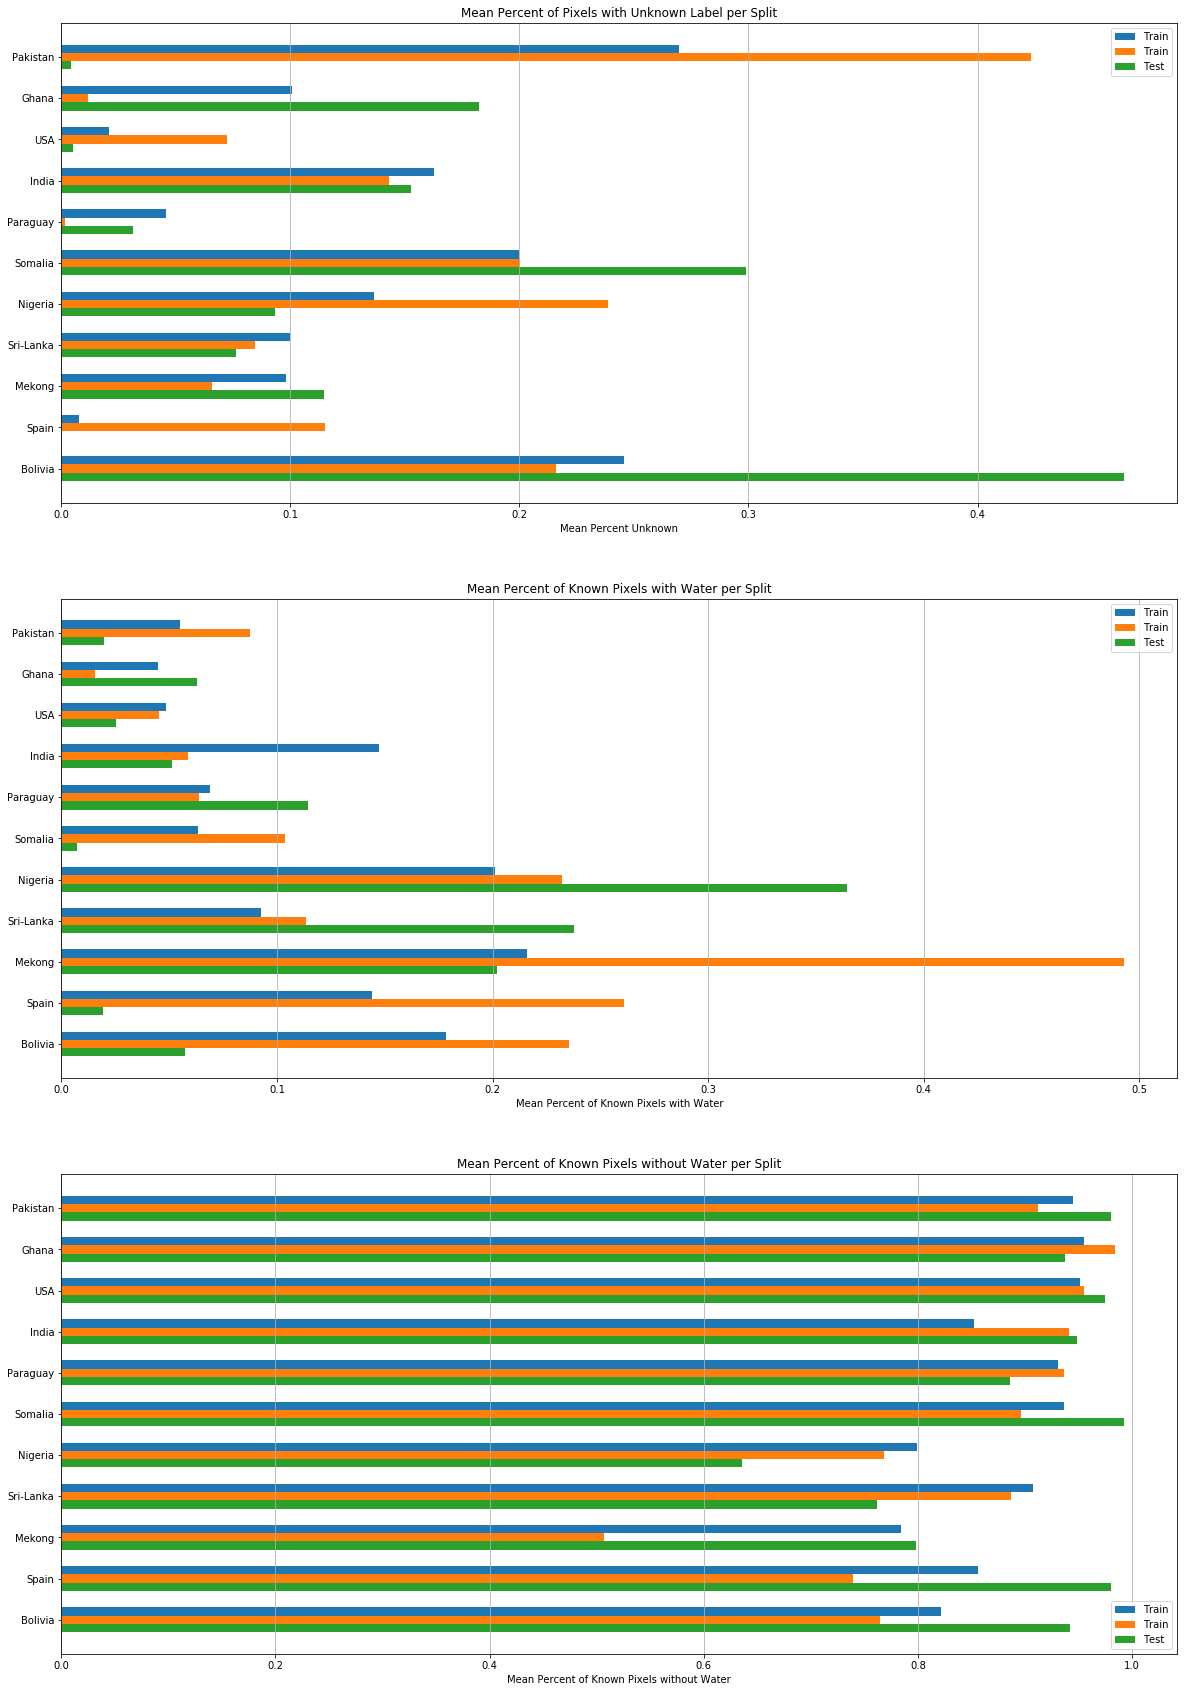

In [83]:
# Quality Check: Visualize some summary statistics

y_pos = np.arange(len(countries_present))
width = 0.2

fig = plt.figure(figsize=(20, 30))

## Visualize percent unknown

ax = fig.add_subplot(3,1,1)
rects1 = ax.barh(y_pos + width, [train_df[train_df['country'] == country].mean()['perc_unknown'] for country in countries_present], width, label='Train') # train "first"
rects2 = ax.barh(y_pos, [val_df[val_df['country'] == country].mean()['perc_unknown'] for country in countries_present], width, label='Val') # val "middle"
rects3 = ax.barh(y_pos - width, [test_df[test_df['country'] == country].mean()['perc_unknown'] for country in countries_present], width, label='Test')   # test "below"

ax.set_xlabel('Mean Percent Unknown')
ax.set_title('Mean Percent of Pixels with Unknown Label per Split')
ax.set_yticks(y_pos)
ax.set_yticklabels(countries_present)

ax.legend()
ax.grid(axis='x')

## Visualize percent known water

ax = fig.add_subplot(3,1,2)
rects1 = ax.barh(y_pos + width, [train_df[train_df['country'] == country].mean()['perc_water_known'] for country in countries_present], width, label='Train') # train "first"
rects2 = ax.barh(y_pos, [val_df[val_df['country'] == country].mean()['perc_water_known'] for country in countries_present], width, label='Val') # val "middle"
rects3 = ax.barh(y_pos - width, [test_df[test_df['country'] == country].mean()['perc_water_known'] for country in countries_present], width, label='Test')   # test "below"

ax.set_xlabel('Mean Percent of Known Pixels with Water')
ax.set_title('Mean Percent of Known Pixels with Water per Split')
ax.set_yticks(y_pos)
ax.set_yticklabels(countries_present)

ax.legend()
ax.grid(axis='x')

# Visualize percent known dry

ax = fig.add_subplot(3,1,3)
rects1 = ax.barh(y_pos + width, [train_df[train_df['country'] == country].mean()['perc_dry_known'] for country in countries_present], width, label='Train') # train "first"
rects2 = ax.barh(y_pos, [val_df[val_df['country'] == country].mean()['perc_dry_known'] for country in countries_present], width, label='Val') # val "middle"
rects3 = ax.barh(y_pos - width, [test_df[test_df['country'] == country].mean()['perc_dry_known'] for country in countries_present], width, label='Test')   # test "below"

ax.set_xlabel('Mean Percent of Known Pixels without Water')
ax.set_title('Mean Percent of Known Pixels without Water per Split')
ax.set_yticks(y_pos)
ax.set_yticklabels(countries_present)

ax.legend()
ax.grid(axis='x')
fig.show()

## Training

__Todo__
- Train a segmentation model in a deep learning framework of your choice (preferably PyTorch) using your train/val/test splits and the S1 images and masks. Validate on the average of the IoUs of individual countries and save your best models for validation and testing.
- Think about and implement how to treat the "no data" pixel values.

Reminder: If you do not have a GPU at hand, you can use https://www.kaggle.com/kernels, https://colab.research.google.com/ for free GPUs or rent a cheap GPU at https://vast.ai/console/create/.

In [16]:
# Specify some training parameters

BATCH_SIZE = 32

In [29]:
# Create Training Dataset

def create_example(asset_id):
    image_fp = os.path.join('c2s_data/v1.1/data/flood_events/HandLabeled/S1Hand', asset_id + '_S1Hand.tif')
    
    # Using the pre-built image reading function since I don't know what the bands are supposed to represent 
    # Also, with 3 channels I can use pretrained model weights easily 
    image = visualize_s1_img(image_fp)
    image = np.nan_to_num(image)
    return image

def create_label(asset_id):
    label_fp = os.path.join('c2s_data/v1.1/data/flood_events/HandLabeled/LabelHand', asset_id + '_LabelHand.tif')
    
    return tifffile.imread(label_fp)

def build_tf_dataset(df, shuffle = True):
    image_dataset = tf.data.Dataset.from_tensor_slices([create_example(x) for x in sorted(df.index)])
    label_dataset = tf.data.Dataset.from_tensor_slices([create_label(x) for x in sorted(df.index)])
    dataset = tf.data.Dataset.zip((image_dataset, label_dataset))
    if shuffle:
        dataset = dataset.shuffle(len(df))
    return dataset

def prepare_model_inputs(image, label):
    #label = tf.reshape(label, [-1])
    
    ### BAD TAKE OUT!!!
    label = tf.math.maximum(label, 0)
    
    return image, label

train_dataset = build_tf_dataset(train_df)
train_dataset = train_dataset.map(prepare_model_inputs)
train_dataset = train_dataset.batch(BATCH_SIZE)

val_dataset = build_tf_dataset(val_df)
val_dataset = val_dataset.map(prepare_model_inputs)
val_dataset = val_dataset.batch(BATCH_SIZE)

In [30]:
if False:

    base_model = tf.keras.applications.ResNet50(
            include_top=False,
            weights="imagenet",
            classes=2,
            input_shape = [IMAGE_HEIGHT, IMAGE_WIDTH, 3]
        )

    base_model.summary()

In [96]:
# Build Model. 

def upsample(filters, size, apply_dropout=False):
    # This is an upsample block implemented in https://www.tensorflow.org/tutorials/generative/pix2pix
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
            padding='same',
            kernel_initializer=initializer,
            use_bias=False)
    )

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())
    return result

def build_model():
    # Loosely based on some code from the keras tutorial https://www.tensorflow.org/tutorials/images/segmentation
    
    ###
    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        weights="imagenet",
        classes=1,
        input_shape = [IMAGE_HEIGHT, IMAGE_WIDTH, 3]
    )
    
    #Use the activations of these layers
    layer_names = [
        'conv1_relu',             # 256x256
        'conv2_block3_out',       # 128x128
        'conv3_block4_out',       # 64x64 
        'conv4_block6_out',       # 32x32
        'conv5_block3_out'        # 16x16
    ]
    ###
    
    base_model_outputs = [base_model.get_layer(name).output for name in layer_names]
    
    # Create the feature extractor
    encoder = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
    encoder.trainable = False
    
    # Create the U-net model
    inputs = tf.keras.layers.Input(shape=[IMAGE_HEIGHT, IMAGE_WIDTH, 3])
    
    x = tf.keras.applications.resnet50.preprocess_input(inputs)
    
    # Downsampling through the model
    skips = encoder(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])
    
    ###
    decoder = [
        upsample(1024, 3),  # 16x16 -> 32x32
        upsample(512, 3),  # 32x32 -> 64x64
        upsample(256, 3),  # 64x64 -> 128x128
        upsample(64, 3)   # 128x128 -> 256x256
    ]
    ###

    # Upsampling and establishing the skip connections
    for up, skip in zip(decoder, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    # Final Layer 256x256 -> 512x512
    x = upsample(64, 3)(x)
    
    # Predictions using a 1x1 convoluation
    predictions = tf.keras.layers.Conv2D(1, 1, strides=1, padding='same')(x)
    
    return tf.keras.Model(inputs = inputs, outputs = predictions)

model = build_model()

In [97]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics=['accuracy'])

In [98]:
model.fit(x = train_dataset, 
          epochs = 100, 
          validation_data = val_dataset
         )

Epoch 1/100
11/11 [==============================] - 9s 613ms/step - loss: 1.1161 - accuracy: 0.4941 - val_loss: 2.1589 - val_accuracy: 0.3363
Epoch 2/100
11/11 [==============================] - 7s 567ms/step - loss: 0.6305 - accuracy: 0.9149 - val_loss: 1.3799 - val_accuracy: 0.5714
Epoch 3/100
11/11 [==============================] - 7s 569ms/step - loss: 0.4690 - accuracy: 0.9053 - val_loss: 0.8025 - val_accuracy: 0.7077
Epoch 4/100
11/11 [==============================] - 7s 569ms/step - loss: 0.3848 - accuracy: 0.9139 - val_loss: 0.5121 - val_accuracy: 0.8136
Epoch 5/100
11/11 [==============================] - 7s 570ms/step - loss: 0.3529 - accuracy: 0.9099 - val_loss: 0.4032 - val_accuracy: 0.9006
Epoch 6/100
11/11 [==============================] - 7s 570ms/step - loss: 0.3431 - accuracy: 0.9029 - val_loss: 0.3598 - val_accuracy: 0.9012
Epoch 7/100
11/11 [==============================] - 7s 570ms/step - loss: 0.3186 - accuracy: 0.9113 - val_loss: 0.3432 - val_accuracy: 0.9012

## Testing/Visualization/Interpretation

__Todo__
- Test your model on the test data and visualize some predictions.
- What strengths and weaknesses does it have? Give specific examples.
- What would be your next steps and biggest levers to improve performance?

In [105]:
tnp = train_dataset.as_numpy_iterator()
vnp = val_dataset.as_numpy_iterator()

In [111]:
x = vnp.next()

In [112]:
i = 4

raw = x[0][i, :, :, :]
prediction = model(x[0])[i, : , :, 0]
truth = x[1][i, : , :]

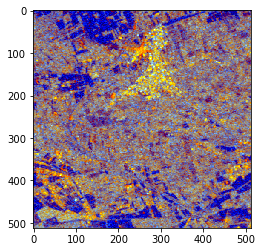

In [113]:
plt.imshow(raw)

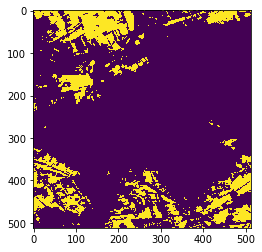

In [114]:
plt.imshow(truth)

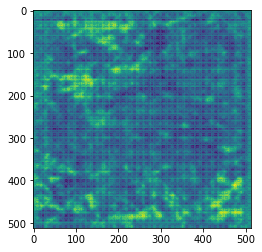

In [115]:
plt.imshow(prediction)

# Part 2: Implementing a custom model for non-standard tasks

Now, we want to design and test our own custom model that uses a standard U-Net architecture, but has custom inputs and outputs. As a starting point you can use any open-source implementation of U-Net like from [here](https://github.com/milesial/Pytorch-UNet).

__Todo: Change a standard U-Net model to work with the following non-standard inputs and outputs in a deep learning framework of your choice (preferably PyTorch).__

- __inputs__: a 10m resolution SAR image (2 channels), a 20m resolution Digital Elevation Model (1 channel) and a sequence of 8 passive microwave readings (1 channel per reading) at a 160m resolution
- __outputs__: a 10m resolution binary water segmentation mask and a 10m resolution binary cloud segmentation mask of the same height/width as the input SAR image
- test your model with input tensors with random data in it to see if intermediate and output shapes are correct

# Thanks for doing the challenge! 

Please send us everything we need to run your code to administration@cloudtostreet.info and philip@cloudtostreet.info